## Tools

In [3]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

## Dataset

In [9]:
col_names = ['contour number', 'aspect ratio', 'extent', 'Blue', 'Green', 'Red', 'Hue', 'class']
data = pd.read_csv("output.csv", skiprows=1, header=None, names=col_names)
data.head(10)

,contour number,aspect ratio,extent,Blue,Green,Red,Hue,class
0,28,0.923077,0.803775,42.769815,97.239460,115.102867,19.023609,0
1,68,0.979804,0.836557,63.621205,104.295904,104.446747,29.446747,0
2,51,0.760961,0.823015,59.701164,99.514131,103.025769,32.987531,0
3,31,0.957265,0.767948,50.077372,116.466180,137.658394,22.445255,0
4,50,0.828162,0.845766,60.658955,104.919383,113.961094,34.713985,0
5,47,0.890923,0.828608,52.141768,97.165096,107.391655,28.818304,0
6,45,0.950329,0.748096,48.570281,121.473896,109.674699,15.439759,0
7,39,0.901044,0.802361,56.255943,103.945878,107.513404,25.372281,0
8,53,0.539305,0.713518,44.690566,132.909434,108.475472,15.988679,0
9,47,0.915618,0.802961,51.757838,96.647207,110.642883,25.927928,0


## Basic EDA

<AxesSubplot:>

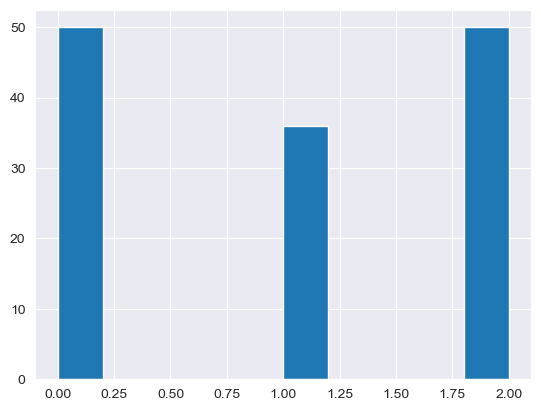

In [10]:
data["class"].hist()

<AxesSubplot:>

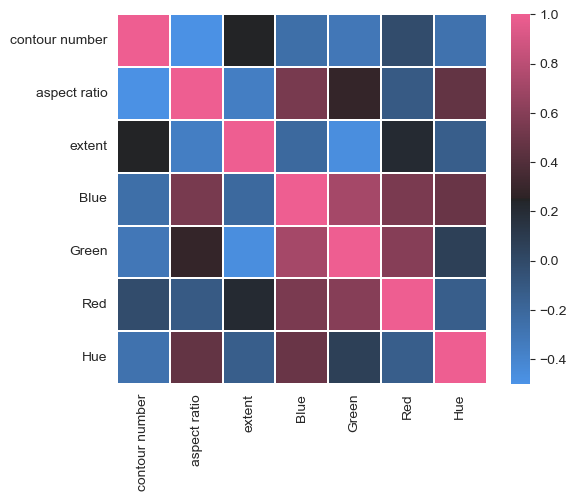

In [11]:
corr = data.iloc[:,:-1].corr(method="pearson")
cmap = sns.diverging_palette(250,354,80,60,center='dark',as_cmap=True)
sns.heatmap(corr, vmax=1, vmin=-.5, cmap=cmap, square=True, linewidths=.2)

In [12]:
data = data[['contour number', 'aspect ratio', 'extent', 'Blue', 'Green', 'Red', 'Hue', 'class']]
data.head(10)

,contour number,aspect ratio,extent,Blue,Green,Red,Hue,class
0,28,0.923077,0.803775,42.769815,97.239460,115.102867,19.023609,0
1,68,0.979804,0.836557,63.621205,104.295904,104.446747,29.446747,0
2,51,0.760961,0.823015,59.701164,99.514131,103.025769,32.987531,0
3,31,0.957265,0.767948,50.077372,116.466180,137.658394,22.445255,0
4,50,0.828162,0.845766,60.658955,104.919383,113.961094,34.713985,0
5,47,0.890923,0.828608,52.141768,97.165096,107.391655,28.818304,0
6,45,0.950329,0.748096,48.570281,121.473896,109.674699,15.439759,0
7,39,0.901044,0.802361,56.255943,103.945878,107.513404,25.372281,0
8,53,0.539305,0.713518,44.690566,132.909434,108.475472,15.988679,0
9,47,0.915618,0.802961,51.757838,96.647207,110.642883,25.927928,0


ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

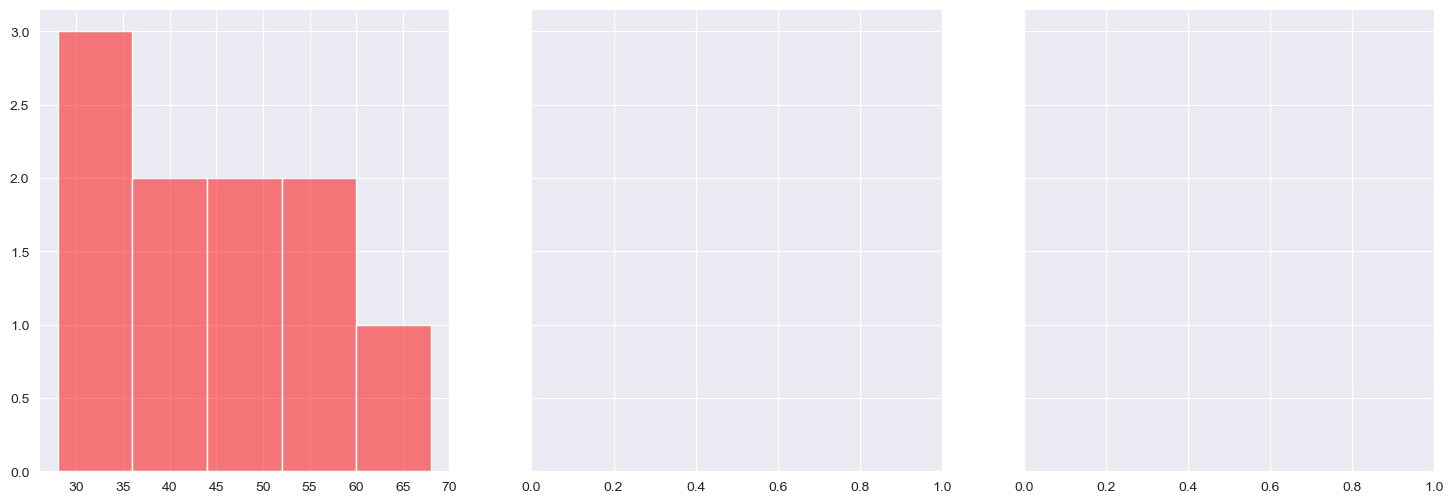

In [16]:
#print(data['contour number'])
data_series = pd.Series([28, 68, 51, 31, 50, 56, 56, 41, 31, 36])
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
sns.histplot(data_series, kde=True, color='r', ax=axes[0])

# fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
# sns.histplot(data, ax=axes[0], x='contour number', kde=True, color='r')
# sns.histplot(data, ax=axes[1], x='aspect ratio', kde=True, color='b')
# sns.histplot(data, ax=axes[2], x='extent', kde=True)
# sns.histplot(data, ax=axes[2], x='Blue', kde=True)
# sns.histplot(data, ax=axes[2], x='Green', kde=True)
# sns.histplot(data, ax=axes[2], x='Red', kde=True)
# sns.histplot(data, ax=axes[2], x='Hue', kde=True)


## Calculate P(Y=y) for all possible y

In [17]:
def calculate_prior(df, Y):
    classes = sorted(list(df[Y].unique()))
    prior = []
    for i in classes:
        prior.append(len(df[df[Y]==i])/len(df))
    return prior

## Approach 1: Calculate P(X=x|Y=y) using Gaussian dist.

In [18]:
def calculate_likelihood_gaussian(df, feat_name, feat_val, Y, label):
    feat = list(df.columns)
    df = df[df[Y]==label]
    mean, std = df[feat_name].mean(), df[feat_name].std()
    p_x_given_y = (1 / (np.sqrt(2 * np.pi) * std)) *  np.exp(-((feat_val-mean)**2 / (2 * std**2 )))
    return p_x_given_y

## Calculate P(X=x1|Y=y)P(X=x2|Y=y)...P(X=xn|Y=y) * P(Y=y) for all y and find the maximum

In [19]:
def naive_bayes_gaussian(df, X, Y):
    # get feature names
    features = list(df.columns)[:-1]

    # calculate prior
    prior = calculate_prior(df, Y)

    Y_pred = []
    # loop over every data sample
    for x in X:
        # calculate likelihood
        labels = sorted(list(df[Y].unique()))
        likelihood = [1]*len(labels)
        for j in range(len(labels)):
            for i in range(len(features)):
                likelihood[j] *= calculate_likelihood_gaussian(df, features[i], x[i], Y, labels[j])

        # calculate posterior probability (numerator only)
        post_prob = [1]*len(labels)
        for j in range(len(labels)):
            post_prob[j] = likelihood[j] * prior[j]

        Y_pred.append(np.argmax(post_prob))

    return np.array(Y_pred) 

## Test Gaussian model

In [21]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=.2, random_state=41)

X_test = test.iloc[:,:-1].values
Y_test = test.iloc[:,-1].values
Y_pred = naive_bayes_gaussian(train, X=X_test, Y="class")

from sklearn.metrics import confusion_matrix, f1_score
print(confusion_matrix(Y_test, Y_pred))
print(f1_score(Y_test, Y_pred))

[[11  0  0]
 [ 0  6  0]
 [ 2  0  9]]


ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].

## Convert continuous features to Categorical features

In [ ]:
data["cat_mean_radius"] = pd.cut(data["mean_radius"].values, bins = 3, labels = [0,1,2])
data["cat_mean_texture"] = pd.cut(data["mean_texture"].values, bins = 3, labels = [0,1,2])
data["cat_mean_smoothness"] = pd.cut(data["mean_smoothness"].values, bins = 3, labels = [0,1,2])

data = data.drop(columns=["mean_radius", "mean_texture", "mean_smoothness"])
data = data[["cat_mean_radius",	"cat_mean_texture",	"cat_mean_smoothness", "diagnosis"]]
data.head(10)

,cat_mean_radius,cat_mean_texture,cat_mean_smoothness,diagnosis
0,1,0,1,0
1,1,0,0,0
2,1,1,1,0
3,0,1,2,0
4,1,0,1,0
5,0,0,2,0
6,1,1,1,0
7,0,1,1,0
8,0,1,2,0
9,0,1,1,0


## Approach 2: Calculate P(X=x|Y=y) categorically

In [ ]:
def calculate_likelihood_categorical(df, feat_name, feat_val, Y, label):
    feat = list(df.columns)
    df = df[df[Y]==label]
    p_x_given_y = len(df[df[feat_name]==feat_val]) / len(df)
    return p_x_given_y

## Calculate P(X=x1|Y=y)P(X=x2|Y=y)...P(X=xn|Y=y) * P(Y=y) for all y and find the maximum

In [ ]:
def naive_bayes_categorical(df, X, Y):
    # get feature names
    features = list(df.columns)[:-1]

    # calculate prior
    prior = calculate_prior(df, Y)

    Y_pred = []
    # loop over every data sample
    for x in X:
        # calculate likelihood
        labels = sorted(list(df[Y].unique()))
        likelihood = [1]*len(labels)
        for j in range(len(labels)):
            for i in range(len(features)):
                likelihood[j] *= calculate_likelihood_categorical(df, features[i], x[i], Y, labels[j])

        # calculate posterior probability (numerator only)
        post_prob = [1]*len(labels)
        for j in range(len(labels)):
            post_prob[j] = likelihood[j] * prior[j]

        Y_pred.append(np.argmax(post_prob))

    return np.array(Y_pred) 

## Test Categorical model

In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=.2, random_state=41)

X_test = test.iloc[:,:-1].values
Y_test = test.iloc[:,-1].values
Y_pred = naive_bayes_categorical(train, X=X_test, Y="diagnosis")

from sklearn.metrics import confusion_matrix, f1_score
print(confusion_matrix(Y_test, Y_pred))
print(f1_score(Y_test, Y_pred))

[[38  2]
 [ 5 69]]
0.9517241379310345
